# Imports

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn, optim
from tqdm import tqdm

# Load the Dataset

In [26]:
from google.colab import drive
import pandas as pd
import json

In [23]:
drive.mount('/content/drive')

with open('/content/drive/MyDrive/SST2_Train.json', 'r') as f:
    train_data = json.load(f)

with open('/content/drive/MyDrive/SST2_Test.json', 'r') as f:
    test_data = json.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Encode

In [5]:
# Convert the data to pandas DataFrame
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Check data distribution
print("Train Data Distribution:")
print(train_df['label'].value_counts())

# Tokenize and prepare data for input and output
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(data):
    encoded_data = tokenizer(data['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
    labels = torch.tensor([1 if label == 'positive' else 0 for label in data['label']])
    return encoded_data, labels

train_inputs, train_labels = preprocess_data(train_df)
test_inputs, test_labels = preprocess_data(test_df)

Train Data Distribution:
positive    3893
negative    3554
Name: label, dtype: int64


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Debug

In [6]:
# Debug
print(train_inputs)
print(train_inputs["input_ids"][0])
print(train_df["text"][0])

{'input_ids': tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
        [  101,  4593,  2128,  ...,     0,     0,     0],
        [  101,  2027,  3653,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2288,  ...,     0,     0,     0],
        [  101, 18318,  7951,  ...,     0,     0,     0],
        [  101, 14308, 21354,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
tensor([  101,  1037, 18385,  1010,  6057,  1998,  2633, 18276,  2128,  1011,
        16603,  1997,  5053,  1998,  1996,  6841,  1998,  5687,  5469, 

# Train

In [7]:
# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define DataLoader
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5) # 5e-5, 3e-5

# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids, attention_mask, labels = (item.to(device) for item in batch)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss}')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 931/931 [02:04<00:00,  7.50it/s]


Epoch 1/3, Average Loss: 0.3175753550463937


Epoch 2/3: 100%|██████████| 931/931 [02:01<00:00,  7.64it/s]


Epoch 2/3, Average Loss: 0.1393069535589884


Epoch 3/3: 100%|██████████| 931/931 [02:00<00:00,  7.71it/s]

Epoch 3/3, Average Loss: 0.06412477686823166


# Classification Report

In [15]:
# Evaluation on test data
model.eval()
with torch.no_grad():
    test_inputs = {key: val.to(device) for key, val in test_inputs.items()}
    outputs = model(**test_inputs)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Evaluate the model
print("\nClassification Report:\n")
print(classification_report(test_labels, predictions))


Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       912
           1       0.86      0.97      0.91       909

    accuracy                           0.90      1821
   macro avg       0.91      0.90      0.90      1821
weighted avg       0.91      0.90      0.90      1821



# Confusion Matrix

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

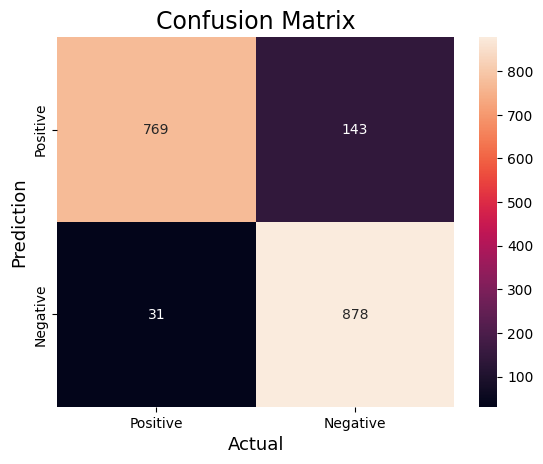

In [17]:
#compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

#Plot the confusion matrix
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# Example Output (Randomly Selected Elements)

In [25]:
import random

In [24]:
print("\nResults for Five Randomly Selected Elements:\n")
print("------------------------------------------------")
print("Text\t\t\t\t\t\t\tPredicted Label\t\tActual Label")
print("------------------------------------------------")

# Randomly select 5 indices from the test subset
random_indices = random.sample(range(len(test_df)), 5)

# Iterate over the randomly selected indices
for idx in random_indices:
    text = test_df.iloc[idx]['text']
    actual_label = test_df.iloc[idx]['label']

    # Tokenize and prepare the data for prediction
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_label = torch.argmax(outputs.logits, dim=1).item()
        predicted_label = 'positive' if predicted_label == 1 else 'negative'

    # Print the results
    print(f"{text[:50]:<50}\t\t{predicted_label:<20}\t\t{actual_label}")


Results for Five Randomly Selected Elements:

------------------------------------------------
Text							Predicted Label		Actual Label
------------------------------------------------
i hate this movie                                 		negative            		negative
you have to pay attention to follow all the storie		positive            		positive
in his debut as a film director , denzel washingto		positive            		positive
the story itself is uninteresting , and the songs 		negative            		negative
despite some gulps the film is a fuzzy huggy      		positive            		positive
